# 🧪 Custom Multilayer Perceptron

In this notebook, we implement linear regression **from scratch**. We then compare the performance of these implementations with **tourch**'s model.

### ⚙️ Importing Libraries & Environment Setup

In [135]:
from abc import ABC, abstractmethod
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [136]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [137]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    )

    for name, y_pred in predictions.items():
        y_pred_bin = y_pred > 0.5
        accuracy = accuracy_score(y, y_pred_bin)
        precision = precision_score(y, y_pred_bin)
        recall = recall_score(y, y_pred_bin)
        f1 = f1_score(y, y_pred_bin)
        roc_auc = roc_auc_score(y, y_pred)

        evaluations.loc[:, name] = [accuracy, precision, recall, f1, roc_auc]

    return evaluations.astype(float)

In [138]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [139]:
X, y = load_breast_cancer(return_X_y=True)
y = y.astype(np.float64).reshape(-1, 1)

In [140]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

In [141]:
# Torch tensors
X_train_t = torch.tensor(X_train.T, dtype=torch.float32)
y_train_t = torch.tensor(y_train.T, dtype=torch.float32)
X_test_t = torch.tensor(X_test.T, dtype=torch.float32)
y_test_t = torch.tensor(y_test.T, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

### 🧠 Implementing Custom Model Algorithms

In [142]:
class WeightInitializer:
    """Инициализатор весов нейронной сети по имени стратегии и распределения.

    Предоставляет единый интерфейс для генерации матриц весов на основе строкового имени
    инициализатора в формате <strategy>_<distribution>. Поддерживает стратегии random,
    xavier и kaiming, 2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transа также распределения normal и uniform.

    Attributes:
        _rng (RandomGenerator): Генератор случайных чисел.
    """

    def __init__(self, rng: RandomGenerator | None = None):
        """Инициализирует объект инициализации весов.

        Args:
            rng (RandomGenerator | None): Генератор случайных чисел. Если не задан,
                используется генератор по умолчанию np.random.default_rng().
        """
        self._rng: RandomGenerator = rng or np.random.default_rng()

    def _normal(self, var: float, shape: tuple[int, int]) -> np.ndarray:
        """Генерирует матрицу весов из нормального распределения с заданным масштабом.

        Args:
            var (float): Параметр масштаба распределения, используемый при генерации.
            shape (tuple[int, int]): Форма генерируемой матрицы весов.

        Returns:
            np.ndarray: Матрица весов указанной формы.
        """
        return self._rng.normal(0, var, shape)

    def _uniform(self, var: float, shape: tuple[int, int]) -> np.ndarray:
        """Генерирует матрицу весов из равномерного распределения с заданным масштабом.

        Масштаб преобразуется к границам равномерного распределения так, чтобы
        соответствовать выбранной стратегии инициализации.

        Args:
            var (float): Базовый параметр масштаба.
            shape (tuple[int, int]): Форма генерируемой матрицы весов.

        Returns:
            np.ndarray: Матрица весов указанной формы.
        """
        bound = np.sqrt(3 * var)
        return self._rng.uniform(-bound, bound, shape)

    def _parse_name(self, name: str) -> tuple[str, str]:
        """Разбирает имя инициализатора на стратегию и распределение.

        Ожидаемый формат имени: <strategy>_<distribution>, например "xavier_uniform".

        Args:
            name (str): Имя инициализатора в строковом формате.

        Raises:
            ValueError: Если строка не соответствует формату <strategy>_<distribution>.

        Returns:
            tuple[str, str]: Кортеж из стратегии и распределения.
        """
        parts = name.split("_")

        if len(parts) != 2:
            raise ValueError(
                f"Invalid format '{name}'. Expected format: <strategy>_<distribution>"
            )

        return tuple(parts)

    def __call__(self, name: str, shape: tuple[int, int]) -> np.ndarray:
        """Создаёт матрицу весов согласно выбранной стратегии и распределению.

        Поддерживаемые стратегии:
            - random: Масштаб 1 / n_in.
            - xavier: Масштаб 2 / (n_in + n_out).
            - kaiming: Масштаб 2 / n_in.

        Поддерживаемые распределения:
            - normal: Нормальное распределение.
            - uniform: Равномерное распределение.

        Args:
            name (str): Имя инициализатора в формате <strategy>_<distribution>.
            shape (tuple[int, int]): Форма матрицы весов (n_in, n_out).

        Raises:
            ValueError: Если указана неподдерживаемая стратегия инициализации.
            ValueError: Если указано неподдерживаемое распределение.

        Returns:
            np.ndarray: Матрица весов указанной формы.
        """
        fan_in, fan_out = shape
        strategy, dist = self._parse_name(name)

        match strategy:
            case "random":
                var = 1 / fan_in
            case "xavier":
                var = 2 / (fan_in + fan_out)
            case "kaiming":
                var = 2 / fan_in
            case _:
                raise ValueError(f"Unknown strategy: {strategy}")

        match dist:
            case "normal":
                return self._normal(var, shape)
            case "uniform":
                return self._uniform(var, shape)
            case _:
                raise ValueError(f"Unknown distribution: {dist}")

In [143]:
class Layer(ABC):
    """Базовый абстрактный класс слоя нейронной сети.

    Определяет общий интерфейс для всех слоёв модели, включая методы
    прямого и обратного распространения, шаг обновления параметров,
    а также переключение между режимами обучения и инференса.
    """

    def __init__(self, weight_init: str = "random_uniform") -> None:
        """Инициализирует базовый слой.

        Args:
            weight_init (str): Имя стратегии инициализации весов,
                используемое при создании параметров слоя.
        """
        self.weight_init = weight_init
        self.is_train = True

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Выполняет прямой проход слоя.

        Args:
            x (np.ndarray): Входные данные слоя.

        Returns:
            np.ndarray: Результат преобразования входных данных.
        """
        pass

    @abstractmethod
    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Выполняет обратное распространение градиента через слой.

        Args:
            grad (np.ndarray): Градиент функции потерь по выходу слоя.

        Returns:
            np.ndarray: Градиент функции потерь по входу слоя.
        """
        pass

    def step(self, _lr: float) -> None:
        """Выполняет шаг обновления параметров слоя.

        Базовая реализация предназначена для слоёв без обучаемых параметров.

        Args:
            _lr (float): Скорость обучения.
        """
        return

    def train(self) -> None:
        """Переводит слой в режим обучения."""
        self.is_train = True

    def eval(self) -> None:
        """Переводит слой в режим инференса."""
        self.is_train = False


class Linear(Layer):
    """Полносвязный линейный слой нейронной сети.

    Выполняет аффинное преобразование входных данных по формуле:
        z = W @ x + b
    """

    def __init__(
        self, in_dim: int, out_dim: int, weight_init: str = "previous"
    ) -> None:
        """Инициализирует линейный слой с заданной размерностью.

        Args:
            in_dim (int): Число входных признаков.
            out_dim (int): Число выходных признаков.
            weight_init (str): Имя стратегии инициализации весов.
        """
        super().__init__(weight_init)

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.w: np.ndarray | None = None
        self.b = np.zeros((out_dim, 1))

        self.x: np.ndarray | None = None
        self.z: np.ndarray | None = None

        self.dw: np.ndarray | None = None
        self.db: np.ndarray | None = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Выполняет прямой проход линейного слоя.

        Args:
            x (np.ndarray): Входной тензор формы (in_dim, batch_size).

        Returns:
            np.ndarray: Выходной тензор формы (out_dim, batch_size).
        """
        if self.w is None:
            raise RuntimeError("Cannot call forward() before initializing weights.")

        self.x = x
        self.z = self.w @ x + self.b
        return self.z

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Вычисляет градиенты по параметрам и по входу слоя.

        Args:
            grad (np.ndarray): Градиент функции потерь по выходу слоя.

        Returns:
            np.ndarray: Градиент функции потерь по входу слоя.
        """
        if self.x is None:
            raise RuntimeError("Cannot call backward() before forward().")

        self.dw = grad @ self.x.T
        self.db = np.sum(grad, axis=1, keepdims=True)

        grad_x = self.w.T @ grad
        return grad_x

    def step(self, lr: float) -> None:
        """Обновляет параметры слоя с использованием вычисленных градиентов.

        Args:
            lr (float): Скорость обучения.
        """
        if self.db is None or self.dw is None:
            raise RuntimeError("Cannot call backward() before forward().")

        self.w -= lr * self.dw
        self.b -= lr * self.db


class Sigmoid(Layer):
    """Сигмоидная функция активации.

    Преобразует входные значения в диапазон (0, 1) по формуле:
        σ(z) = 1 / (1 + exp(-z))
    """

    def __init__(self, weight_init: str = "kaiming_uniform") -> None:
        """Инициализирует слой сигмоидной активации.

        Args:
            weight_init (str): Имя стратегии инициализации,
                передаётся для согласованности интерфейса.
        """
        super().__init__(weight_init)

        self.y: np.ndarray | None = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Выполняет прgrad_xямой проход сигмоидной активации.

        Args:
            x (np.ndarray): Входной тензор предактивации.

        Returns:
            np.ndarray: Выходной тензор после применения сигмоиды.
        """
        self.y = 1 / (1 + np.exp(-x))
        return self.y

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Вычисляет градиент сигмоиды по входу.

        Args:
            grad (np.ndarray): Градиент функции потерь по выходу слоя.

        Returns:
            np.ndarray: Градиент функции потерь по входу слоя.
        """
        if self.y is None:
            raise RuntimeError("Cannot call backward() before forward().")

        return grad * self.y * (1 - self.y)


class ReLU(Layer):
    """Функция активации ReLU (Rectified Linear Unit).

    Выполняет преобразование:
        f(x) = max(0, x)
    """

    def __init__(self, weight_init: str = "xavier_uniform") -> None:
        """Инициализирует слой ReLU.

        Args:
            weight_init (str): Имя стратегии инициализации,
                передаётся для согласованности интерфейса.
        """
        super().__init__(weight_init)

        self.mask: np.ndarray | None = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Применяет функцию ReLU к входным данным.

        Args:
            x (np.ndarray): Входной тензор.

        Returns:
            np.ndarray: Выходной тензор после применения ReLU.
        """
        self.mask = x > 0
        return x * self.mask

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Вычисляет градиент ReLU по входу.

        Args:
            grad (np.ndarray): Градиент функции потерь по выходу слоя.

        Returns:
            np.ndarray: Градиент функции потерь по входу слоя.
        """
        if self.mask is None:
            raise RuntimeError("Cannot call backward() before forward().")

        return grad * self.mask


class Softmax(Layer):
    """Функция активации softmax.

    Выполняет преобразование:
        f(z) = esp(z) / sum(exp(z))
    """

    def __init__(self, weight_init: str = "kaiming_uniform") -> None:
        """Инициализирует слой Softmax.

        Args:
            weight_init (str): Имя стратегии инициализации,
                передаётся для согласованности интерфейса.
        """
        super().__init__(weight_init)

        self.y: np.ndarray | None = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Применяет функцию Softmax к входным данным.

        Args:
            x (np.ndarray): Входной тензор.

        Returns:
            np.ndarray: Выходной тензор после применения Softmax.
        """
        shifted_x = x - np.max(x, axis=0, keepdims=True)
        exp_x = np.exp(shifted_x)
        self.y = exp_x / np.sum(exp_x, axis=0, keepdims=True)
        return self.y

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Вычисляет градиент Softmax по входу.

        Args:
            grad (np.ndarray): Градиент функции потерь по выходу слоя.

        Returns:
            np.ndarray: Градиент функции потерь по входу слоя.
        """
        if self.y is None:
            raise RuntimeError("Cannot call backward() before forward().")

        batch_size = self.y.shape[0]
        dx = np.zeros_like(grad)

        for i in range(batch_size):
            s = self.y[i].reshape(-1, 1)
            jacobian = np.diagflat(s) - np.dot(s, s.T)
            dx[i] = np.dot(jacobian, grad[i])

        return dx


class Dropout(Layer):
    """Слой Dropout для регуляризации нейронной сети.

    В режиме обучения случайно зануляет элементы входа с вероятностью p
    и масштабирует оставшиеся элементы для сохранения математического ожидания.
    """

    def __init__(self, p: float, weight_init: str = "previous") -> None:
        """Инициализирует слой Dropout.

        Args:
            p (float): Вероятность зануления элемента.
            weight_init (str): Имя стратегии инициализации,
                передаётся для согласованности интерфейса.
        """
        super().__init__(weight_init)

        self.p = p
        self.mask: np.ndarray | None = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Применяет Dropout к входным данным в режиме обучения.

        Args:
            x (np.ndarray): Входные данные слоя.

        Returns:
            np.ndarray: Выходные данные после применения маски Dropout.
        """
        if not self.is_train or self.p == 0:
            return x

        self.mask = (np.random.rand(*x.shape) > self.p).astype(x.dtype)
        self.mask /= 1.0 - self.p

        return x * self.mask

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Применяет маску Dropout к градиенту на обратном проходе.

        Args:
            grad (np.ndarray): Градиент функции потерь по выходу слоя.

        Returns:
            np.ndarray: Градиент функции потерь по входу слоя.
        """
        if self.mask is None:
            raise RuntimeError("Cannot call backward() before forward().")

        return grad * self.mask


class Batchnorm(Layer):
    """Слой Batch Normalization (для 2D тензоров формы (features, batch_size)).

    Нормализует признаки по батчу:
        x_hat = (x - mean) / sqrt(var + eps)
        y = gamma * x_hat + beta

    Во время инференса использует скользящие оценки mean/var.
    """

    def __init__(
        self,
        n_in: int,
        eps: float = 1e-5,
        momentum: float = 0.9,
        weight_init: str = "previous",
    ) -> None:
        """Инициализирует слой Dropout.

        Args:
            n_in (int): Число входных признаков.
            eps (float): Малое число для численной стабильности в знаменателе.
            momentum (float): Коэффициент экспоненциального сглаживания для
                обновления running_mean и running_var.
            weight_init (str): Имя стратегии инициализации,
                передаётся для согласованности интерфейса.
        """
        super().__init__(weight_init)

        self.n_in = n_in
        self.eps = eps
        self.momentum = momentum

        self.gamma = np.ones((n_in, 1))
        self.beta = np.zeros((n_in, 1))

        self.dgamma: np.ndarray | None = None
        self.dbeta: np.ndarray | None = None

        self.running_mean = np.zeros((n_in, 1))
        self.running_var = np.ones((n_in, 1))

        self.x: np.ndarray | None = None
        self.x_hat: np.ndarray | None = None
        self.mean: np.ndarray | None = None
        self.var: np.ndarray | None = None
        self.inv_std: np.ndarray | None = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Применяет Batchnorm к входным данным в режиме обучения.

        Args:
            x (np.ndarray): Входные данные слоя.

        Returns:
            np.ndarray: Выходные данные после применения Batchnorm.
        """
        self.x = x

        if self.is_train:
            self.mean = np.mean(x, axis=1, keepdims=True)
            self.var = np.var(x, axis=1, keepdims=True)
            self.inv_std = 1.0 / np.sqrt(self.var + self.eps)

            self.x_hat = (x - self.mean) * self.inv_std

            self.running_mean = (
                self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            )
            self.running_var = (
                self.momentum * self.running_var + (1 - self.momentum) * self.var
            )
        else:
            inv_std = 1.0 / np.sqrt(self.running_var + self.eps)
            self.x_hat = (x - self.running_mean) * inv_std

        return self.gamma * self.x_hat + self.beta

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Вычисляет градиент Batchnorm по входу.

        Args:
            grad (np.ndarray): Градиент функции потерь по выходу слоя.

        Returns:
            np.ndarray: Градиент функции потерь по входу слоя.
        """
        if self.x is None or self.x_hat is None:
            raise RuntimeError("Cannot call backward() before forward().")

        # grads for affine part
        self.dbeta = np.sum(grad, axis=1, keepdims=True)
        self.dgamma = np.sum(grad * self.x_hat, axis=1, keepdims=True)

        dxhat = grad * self.gamma

        if not self.is_train:
            inv_std = 1.0 / np.sqrt(self.running_var + self.eps)
            return dxhat * inv_std

        B = self.x.shape[1]
        inv_std = self.inv_std

        sum_dxhat = np.sum(dxhat, axis=1, keepdims=True)
        sum_dxhat_xhat = np.sum(dxhat * self.x_hat, axis=1, keepdims=True)

        return (
            (1.0 / B) * inv_std * (B * dxhat - sum_dxhat - self.x_hat * sum_dxhat_xhat)
        )

    def step(self, lr: float) -> None:
        """Обновляет параметры слоя с использованием вычисленных градиентов.

        Args:
            lr (float): Скорость обучения.
        """
        if self.dgamma is None or self.dbeta is None:
            raise RuntimeError("Cannot call step() before backward().")

        self.gamma -= lr * self.dgamma
        self.beta -= lr * self.dbeta

In [144]:
class NeuralNetwork:
    """Последовательная нейронная сеть, объединяющая набор слоёв.

    Управляет инициализацией весов линейных слоёв, выполнением прямого прохода,
    обратного распространения градиента и обновлением параметров. Также поддерживает
    переключение всех слоёв между режимами обучения и инференса.

    Инициализация весов выполняется с учётом стратегии, указанной в слое. Если для слоя
    задано значение "previous", используется стратегия инициализации, унаследованная
    от последнего встреченного слоя, который явно указал стратегию.

    Attributes:
        layers (list[Layer]): Список слоёв в порядке применения.
        _rng (np.random.Generator): Генератор случайных чисел для воспроизводимости.
        w_init (WeightInitializer): Инициализатор весов.
    """

    def __init__(self, layers: list[Layer], random_state: int | None = None) -> None:
        """Инициализирует нейронную сеть и выполняет инициализацию весов.

        Args:
            layers (list[Layer]): Слои сети в порядке выполнения.
            random_state (int | None): Начальное состояние генератора случайных чисел.
                Если не задано, используется недетерминированная инициализация.
        """
        super().__init__()

        self.layers = layers
        self._rng = np.random.default_rng(random_state)

        self.w_init = WeightInitializer(self._rng)

        self._init_weights()

    def _init_weights(self) -> None:
        """Инициализирует веса линейных слоёв в соответствии с выбранными стратегиями.

        Проходит по слоям в обратном порядке, чтобы определить стратегию инициализации
        для линейных слоёв на основе параметра weight_init. Если слой имеет значение
        "previous", то используется ранее определённая стратегия инициализации.
        """
        prev_init = "random_uniform"
        for layer in self.layers[::-1]:
            if isinstance(layer, Linear):
                init_name = prev_init
                if layer.weight_init != "previous":
                    init_name = layer.weight_init
                layer.w = self.w_init(init_name, (layer.out_dim, layer.in_dim))

            layer_init = layer.weight_init
            if layer_init != "previous":
                prev_init = layer_init

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Выполняет прямой проход через все слои сети.

        Args:
            x (np.ndarray): Входные данные сети.

        Returns:
            np.ndarray: Выход сети после последовательного применения всех слоёв.
        """
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, grad_out: np.ndarray) -> np.ndarray:
        """Выполняет обратное распространение градиента через все слои сети.

        Args:
            grad_out (np.ndarray): Градиент функции потерь по выходу сети.

        Returns:
            np.ndarray: Градиент функции потерь по входу сети.
        """
        grad = grad_out
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)
        return grad

    def step(self, lr: float) -> None:
        """Обновляет параметры всех слоёв сети с заданной скоростью обучения.

        Args:
            lr (float): Скорость обучения.
        """
        for layer in self.layers:
            layer.step(lr)

    def train(self) -> None:
        """Переводит все слои сети в режим обучения."""
        for layer in self.layers:
            layer.train()

    def eval(self) -> None:
        """Переводит все слои сети в режим инференса."""
        for layer in self.layers:
            layer.eval()

### 🏋️‍♂️ Model Training

In [145]:
my_net = NeuralNetwork(
    [
        Linear(30, 64),
        Batchnorm(64),
        Dropout(0.3),
        ReLU(),
        Linear(64, 32),
        Batchnorm(32),
        Dropout(0.2),
        ReLU(),
        Linear(32, 1),
        Sigmoid(),
    ],
    random_state=42,
)

learning_rate = 0.05
epochs = 200
batch_size = 32
N = X_train.shape[1]

for epoch in range(epochs + 1):
    my_net.train()

    idx = np.random.permutation(N)

    for start in range(0, N, batch_size):
        batch_idx = idx[start : start + batch_size]
        x = X_train[:, batch_idx]
        yb = y_train[:, batch_idx]
        B = x.shape[1]

        y_hat = my_net.forward(x)
        grad = (y_hat - yb) / B
        my_net.backward(grad)
        my_net.step(learning_rate)

    if epoch % 10 == 0:
        my_net.eval()

        y_train_pred = my_net.forward(X_train).ravel()
        y_test_pred = my_net.forward(X_test).ravel()

        y_train_true = y_train.ravel()
        y_test_true = y_test.ravel()

        train_loss = log_loss(y_train_true, y_train_pred)
        train_acc = accuracy_score(y_train_true, y_train_pred > 0.5)
        test_loss = log_loss(y_test_true, y_test_pred)
        test_acc = accuracy_score(y_test_true, y_test_pred > 0.5)

        print(
            f"Epoch {epoch:03d} | "
            f"train_loss: {train_loss:7.4f} | "
            f"train_acc: {train_acc:7.4f} | "
            f"test_loss: {test_loss:7.4f} | "
            f"test_acc: {test_acc:7.4f}"
        )

Epoch 000 | train_loss:  0.3094 | train_acc:  0.8681 | test_loss:  0.2915 | test_acc:  0.8860
Epoch 010 | train_loss:  0.1013 | train_acc:  0.9714 | test_loss:  0.0839 | test_acc:  0.9649
Epoch 020 | train_loss:  0.0834 | train_acc:  0.9780 | test_loss:  0.0897 | test_acc:  0.9737
Epoch 030 | train_loss:  0.0711 | train_acc:  0.9780 | test_loss:  0.0869 | test_acc:  0.9649
Epoch 040 | train_loss:  0.0730 | train_acc:  0.9758 | test_loss:  0.0859 | test_acc:  0.9649
Epoch 050 | train_loss:  0.0587 | train_acc:  0.9824 | test_loss:  0.0926 | test_acc:  0.9561
Epoch 060 | train_loss:  0.0559 | train_acc:  0.9868 | test_loss:  0.1461 | test_acc:  0.9561
Epoch 070 | train_loss:  0.0523 | train_acc:  0.9802 | test_loss:  0.0979 | test_acc:  0.9561
Epoch 080 | train_loss:  0.0515 | train_acc:  0.9846 | test_loss:  0.1103 | test_acc:  0.9649
Epoch 090 | train_loss:  0.0485 | train_acc:  0.9824 | test_loss:  0.1122 | test_acc:  0.9561
Epoch 100 | train_loss:  0.0503 | train_acc:  0.9846 | test_

In [146]:
net = nn.Sequential(
    nn.Linear(30, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 1),
)

criterion = nn.BCEWithLogitsLoss()

lr = 0.05
epochs = 200

for epoch in range(epochs + 1):
    net.train()
    for xb, yb in train_loader:
        # forward
        logits = net(xb)
        loss = criterion(logits, yb)

        # backward
        net.zero_grad(set_to_none=True)
        loss.backward()

        for param in net.parameters():
            if param.grad is not None:
                param.data -= lr * param.grad

    if epoch % 10 == 0:
        net.eval()
        with torch.no_grad():
            train_logits = net(X_train_t)
            test_logits = net(X_test_t)

            train_prob = torch.sigmoid(train_logits).cpu().numpy().ravel()
            test_prob = torch.sigmoid(test_logits).cpu().numpy().ravel()

            y_train_np = y_train_t.cpu().numpy().ravel()
            y_test_np = y_test_t.cpu().numpy().ravel()

            train_loss = log_loss(y_train_np, train_prob)
            test_loss = log_loss(y_test_np, test_prob)
            train_acc = accuracy_score(y_train_np, train_prob > 0.5)
            test_acc = accuracy_score(y_test_np, test_prob > 0.5)

        print(
            f"Epoch {epoch:03d} | "
            f"train_loss: {train_loss:7.4f} | "
            f"train_acc: {train_acc:7.4f} | "
            f"test_loss: {test_loss:7.4f} | "
            f"test_acc: {test_acc:7.4f}"
        )

Epoch 000 | train_loss:  0.4764 | train_acc:  0.9670 | test_loss:  0.4865 | test_acc:  0.9561
Epoch 010 | train_loss:  0.0977 | train_acc:  0.9824 | test_loss:  0.1359 | test_acc:  0.9649
Epoch 020 | train_loss:  0.0612 | train_acc:  0.9824 | test_loss:  0.1018 | test_acc:  0.9737
Epoch 030 | train_loss:  0.0559 | train_acc:  0.9868 | test_loss:  0.0782 | test_acc:  0.9825
Epoch 040 | train_loss:  0.0500 | train_acc:  0.9912 | test_loss:  0.1042 | test_acc:  0.9561
Epoch 050 | train_loss:  0.0310 | train_acc:  0.9868 | test_loss:  0.0774 | test_acc:  0.9649
Epoch 060 | train_loss:  0.0332 | train_acc:  0.9890 | test_loss:  0.0855 | test_acc:  0.9649
Epoch 070 | train_loss:  0.0286 | train_acc:  0.9956 | test_loss:  0.0766 | test_acc:  0.9649
Epoch 080 | train_loss:  0.0259 | train_acc:  0.9934 | test_loss:  0.0636 | test_acc:  0.9825
Epoch 090 | train_loss:  0.0282 | train_acc:  0.9934 | test_loss:  0.0818 | test_acc:  0.9649
Epoch 100 | train_loss:  0.0209 | train_acc:  0.9934 | test_

### 📊 Comparing Algorithm Versions

In [147]:
my_net.eval()
torch_pred = torch.sigmoid(net(X_test_t)).detach().cpu().numpy().ravel()
my_pred = my_net.forward(X_test).ravel()

predictions = {
    "torch": torch_pred,
    "my": my_pred,
}

In [148]:
evaluate_classification_models(predictions, y_test.ravel())

,torch,my
Accuracy,0.973684,0.956140
Precision,0.972603,0.985507
Recall,0.986111,0.944444
F1-score,0.979310,0.964539
ROC AUC,0.998016,0.997024


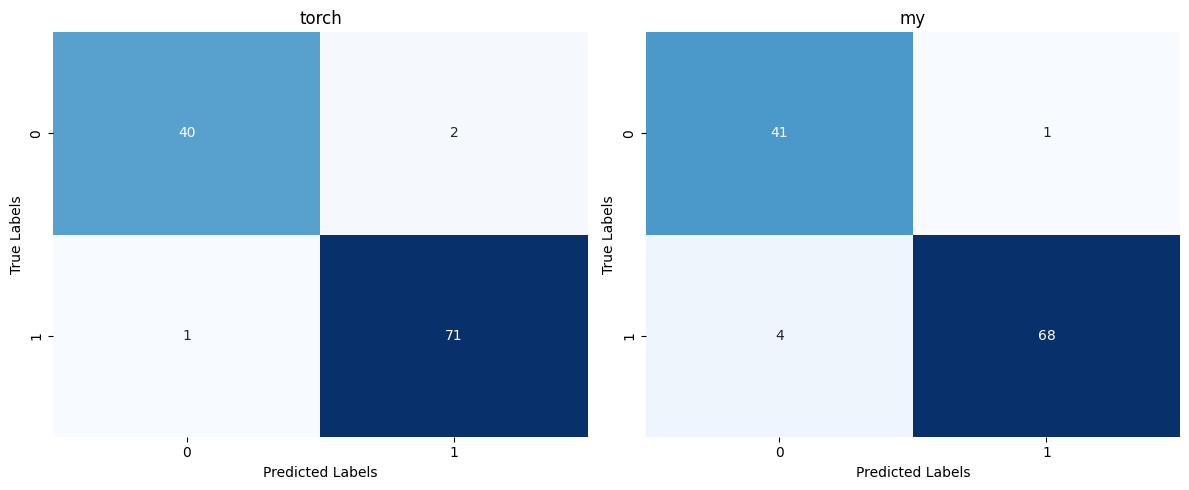

In [149]:
plot_confusion_matrices({k: v > 0.5 for k, v in predictions.items()}, y_test.ravel())